In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Subhalo Alignments

Examine the intrinsic alignment between sub-haloes and thier host halo.

## Load Sub-halo Catalog

In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')
for name in halocat.halo_table.dtype.names:
    print(name)

halo_vmax_firstacc
halo_dmvir_dt_tdyn
halo_macc
halo_scale_factor
halo_vmax_mpeak
halo_m_pe_behroozi
halo_xoff
halo_spin
halo_scale_factor_firstacc
halo_c_to_a
halo_mvir_firstacc
halo_scale_factor_last_mm
halo_scale_factor_mpeak
halo_pid
halo_m500c
halo_id
halo_halfmass_scale_factor
halo_upid
halo_t_by_u
halo_rvir
halo_vpeak
halo_dmvir_dt_100myr
halo_mpeak
halo_m_pe_diemer
halo_jx
halo_jy
halo_jz
halo_m2500c
halo_mvir
halo_voff
halo_axisA_z
halo_axisA_x
halo_axisA_y
halo_y
halo_b_to_a
halo_x
halo_z
halo_m200b
halo_vacc
halo_scale_factor_lastacc
halo_vmax
halo_m200c
halo_vx
halo_vy
halo_vz
halo_dmvir_dt_inst
halo_rs
halo_nfw_conc
halo_hostid
halo_mvir_host_halo


## Define some useful quantities

In [4]:
# get masks for sub-haloes and host-haloes
hosts = (halocat.halo_table['halo_upid']==-1)
subs = (halocat.halo_table['halo_upid']!=-1)

In [5]:
# get the index of each sub-halo's host halo
from halotools.utils import crossmatch, normalized_vectors
inds1, inds2 = crossmatch(halocat.halo_table['halo_hostid'], halocat.halo_table['halo_id'])

In [9]:
# define radial vector between sub-halo and the center of its host halo.
x = np.zeros(len(halocat.halo_table))
y = np.zeros(len(halocat.halo_table))
z = np.zeros(len(halocat.halo_table))
x[inds1] = halocat.halo_table['halo_x'][inds2]
y[inds1] = halocat.halo_table['halo_y'][inds2]
z[inds1] = halocat.halo_table['halo_z'][inds2]

dx = (halocat.halo_table['halo_x'] - x)
dy = (halocat.halo_table['halo_y'] - y)
dz = (halocat.halo_table['halo_z'] - z)

# account for PBCs
mask = (dx>halocat.Lbox[0]/2.0)
dx[mask] = dx[mask] - halocat.Lbox[0]
mask = (dx<-1.0*halocat.Lbox[0]/2.0)
dx[mask] = dx[mask] + halocat.Lbox[0]

mask = (dy>halocat.Lbox[1]/2.0)
dy[mask] = dy[mask] - halocat.Lbox[1]
mask = (dy<-1.0*halocat.Lbox[1]/2.0)
dy[mask] = dy[mask] + halocat.Lbox[1]

mask = (dz>halocat.Lbox[2]/2.0)
dz[mask] = dz[mask] - halocat.Lbox[2]
mask = (dz<-1.0*halocat.Lbox[2]/2.0)
dz[mask] = dz[mask] + halocat.Lbox[2]

# calculate radial distance and radial unit vector
radius = np.sqrt(dx**2+dy**2+dz**2)
r = normalized_vectors(np.vstack((dx, dy, dz)).T)
r = np.nan_to_num(r)

# calculate scaled radial distance (r/r_vir)
scaled_radius = np.zeros(len(halocat.halo_table))
# ignore divide by zero in this case
scaled_radius[inds1] = np.divide(radius[inds1], halocat.halo_table['halo_rvir'][inds2],
                                 out=np.zeros_like(radius[inds1]),
                                 where=halocat.halo_table['halo_rvir'][inds2]!=0)

In [10]:
# define orinetation vecotrs of (sub-)haloes
from halotools.utils import rotation_matrices_from_vectors, elementwise_dot, normalized_vectors
from intrinsic_alignments.ia_models.utils import project_onto_plane

#define major axis of (sub-)haloes
major_axis = normalized_vectors(np.vstack((halocat.halo_table['halo_axisA_x'],
                                           halocat.halo_table['halo_axisA_y'],
                                           halocat.halo_table['halo_axisA_z'])).T)

#define spin axis of (sub-)haloes
spin_axis = normalized_vectors(np.vstack((halocat.halo_table['halo_jx'],
                                          halocat.halo_table['halo_jy'],
                                          halocat.halo_table['halo_jz'])).T)

# define host orientation vectors for each sub-halo
# major axis
host_major_axis = np.copy(major_axis)
host_major_axis[inds1] = major_axis[inds2]
# spin axis
host_spin_axis = np.copy(spin_axis)
host_spin_axis[inds1] = spin_axis[inds2]

In [16]:
# calculate misalignment angles
from halotools.utils import angles_between_list_of_vectors

# major axis
theta_ma_1 = angles_between_list_of_vectors(r, major_axis)
theta_ma_2 = angles_between_list_of_vectors(host_major_axis, major_axis)

# spin axis
theta_ma_3 = angles_between_list_of_vectors(r, spin_axis)
theta_ma_4 = angles_between_list_of_vectors(host_spin_axis, spin_axis)

# Radial Major Axis Alingment

NameError: name 'bins' is not defined

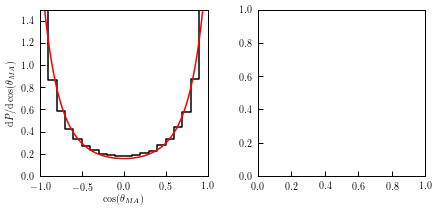

In [19]:
# import misalignment angle distribution model
from intrinsic_alignments.ia_models.ia_model_components import DimrothWatson, inverse_alignment_strenth
d = DimrothWatson()

# define bins
costheta_bins = np.linspace(-1,1,21)
mask = np.isfinite(theta_ma_1) & subs

# calculate differential probability distribution
costheta_1 = np.fabs(np.cos(theta_ma_1[mask]))
uran = np.random.random(len(costheta_1))
costheta_1[uran < 0.5] = -1.0*costheta_1[uran < 0.5] # symmeterize
counts_1 = np.histogram(costheta_1, bins=costheta_bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)/np.diff(costheta_bins)

# fit for shape parameter
k_1 = d.fit(np.cos(theta_ma_1[mask]), floc=0, fscale=1)[0]
full_sample_p_1 = inverse_alignment_strenth(k_1)

# plot results
x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,2,figsize=(6.3,3.3))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, wspace=0.3)

# differential probability distribution
ax = axes[0]
ax.step(costheta_bins[1:], counts_1, '-', color='black')
ax.plot(x, d.pdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')

# cumulative distribution
from intrinsic_alignments.halo_shape_correlations.utils import empirical_cdf
cdf = empirical_cdf(np.cos(theta_ma_1[mask]), bins=bins)[0]

ax=axes[1]
p1, = ax.step(binbs[:-1], cdf, color='black')
p2, = ax.step(x, d.cdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$F[\cos(\theta_{MA})]$')

ax.legend([p1,p2],['sub-haloes','fit'], loc='upper left', frameon=False, fontsize=10)

plt.show()

#check for trends
Nboot=5

# check for radial dependence 
rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0
inds = np.digitize(scaled_radius, bins=rbins)
k = np.zeros((len(rbins)-1,Nboot))
for i in range(0,len(rbins)-1):
    mask = (inds==i) & np.isfinite(theta_ma)
    x = np.cos(theta_ma_1[mask])
    uran = np.random.random(len(x))
    x[uran < 0.5] = -1.0*x[uran < 0.5]
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

p = np.mean(inverse_alignment_strenth(k), axis=-1)
err_p = np.std(inverse_alignment_strenth(k), axis=-1)

ax=axes[2]
ax.errorbar(rbin_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,2], [full_sample_p_1, full_sample_p_1], '-', color='red')
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlim(0.03,1.1)
ax.set_xlabel(r'$r/r_{\rm vir}$')
ax.set_ylabel(r'$\mu$')

# check for host mass dependence
mbins = np.logspace(11,15,20)
mbins_centers = (mbins[:-1]+mbins[1:])/2.0
inds = np.digitize(halocat.halo_table['halo_mvir_host_halo'], bins=mbins)
k = np.zeros((len(mbins)-1,Nboot))
for i in range(0,len(mbins)-1):
    mask = (inds==i) & np.isfinite(theta_ma)
    x = np.cos(theta_ma_1[mask])
    uran = np.random.random(len(x))
    x[uran < 0.5] = -1.0*x[uran < 0.5]
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

p = np.mean(inverse_alignment_strenth(k), axis=-1)
err_p = np.std(inverse_alignment_strenth(k), axis=-1)
        
ax=axes[3]
ax.errorbar(mbins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,10**16], [full_sample_p_1, full_sample_p_1], '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([10**11,10**14])
ax.set_xscale('log')
ax.set_xlabel('host ' + r'$M_{\rm vir}$')
ax.set_ylabel(r'$\mu$')

plt.show()

fig.savefig('/Users/duncan/Desktop/fig1.pdf', dpi=250)

from scipy.stats import kstest
kstest(np.cos(theta_ma_1[mask]), d.cdf, args=(k_1,))

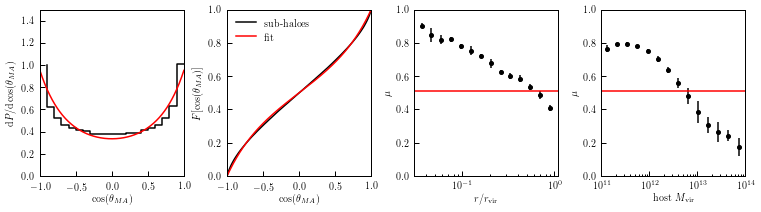

KstestResult(statistic=0.21843376070101375, pvalue=1.847676135909339e-210)

In [225]:
from intrinsic_alignments.ia_models.ia_model_components import DimrothWatson, inverse_alignment_strenth
d = DimrothWatson()

costheta_bins = np.linspace(-1,1,21)
mask = np.isfinite(theta_ma_1) & subs

costheta_2 = np.fabs(np.cos(theta_ma_2[mask]))
uran = np.random.random(len(costheta_2))
costheta_2[uran < 0.5] = -1.0*costheta_2[uran < 0.5]
counts_2 = np.histogram(costheta_2, bins=costheta_bins)[0]
counts_2 = 1.0*counts_2/np.sum(counts_2)/np.diff(costheta_bins)

k_2 = d.fit(np.cos(theta_ma_2[mask]), floc=0, fscale=1)[0]
full_sample_p_2 = inverse_alignment_strenth(k_2)

x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,4,figsize=(14,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.3)
ax = axes[0]
ax.step(costheta_bins[1:], counts_2, '-', color='black')
ax.plot(x, d.pdf(x, k=k_2), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')

cdf_2 = np.ones(len(costheta_2))
cdf_2 = np.cumsum(cdf_2)/np.sum(cdf_2)

ax=axes[1]
p1, = ax.step(np.sort(costheta_2), cdf_2, color='black')
p2, = ax.plot(x, d.cdf(x, k=k_2), '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$F[\cos(\theta_{MA})]$')

ax.legend([p1,p2],['sub-haloes','fit'], loc='upper left', frameon=False, fontsize=10)

#check for trends
Nboot=5

# check for radial dependence 
rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0
inds = np.digitize(scaled_radius, bins=rbins)
k = np.zeros((len(rbins)-1,Nboot))
for i in range(0,len(rbins)-1):
    mask = (inds==i) & np.isfinite(theta_ma)
    x = np.cos(theta_ma_2[mask])
    uran = np.random.random(len(x))
    x[uran < 0.5] = -1.0*x[uran < 0.5]
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

p = np.mean(inverse_alignment_strenth(k), axis=-1)
err_p = np.std(inverse_alignment_strenth(k), axis=-1)

ax=axes[2]
ax.errorbar(rbin_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,2], [full_sample_p_2, full_sample_p_2], '-', color='red')
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlim(0.03,1.1)
ax.set_xlabel(r'$r/r_{\rm vir}$')
ax.set_ylabel(r'$\mu$')

# check for host mass dependence
mbins = np.logspace(11,15,20)
mbins_centers = (mbins[:-1]+mbins[1:])/2.0
inds = np.digitize(halocat.halo_table['halo_mvir_host_halo'], bins=mbins)
k = np.zeros((len(mbins)-1,Nboot))
for i in range(0,len(mbins)-1):
    mask = (inds==i) & np.isfinite(theta_ma)
    x = np.cos(theta_ma_2[mask])
    uran = np.random.random(len(x))
    x[uran < 0.5] = -1.0*x[uran < 0.5]
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

p = np.mean(inverse_alignment_strenth(k), axis=-1)
err_p = np.std(inverse_alignment_strenth(k), axis=-1)
        
ax=axes[3]
ax.errorbar(mbins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,10**16], [full_sample_p_2, full_sample_p_2], '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([10**11,10**14])
ax.set_xscale('log')
ax.set_xlabel('host ' + r'$M_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
        
plt.show()

fig.savefig('/Users/duncan/Desktop/fig2.pdf', dpi=250)

from scipy.stats import kstest
kstest(np.cos(theta_ma_2[mask]), d.cdf, args=(k_2,))

## check for more trends

In [261]:
# check for sub mass dependence
mbins = np.logspace(10,14,20)
mbins_centers = (mbins[:-1]+mbins[1:])/2.0
inds = np.digitize(halocat.halo_table['halo_mvir'], bins=mbins)
Nboot=20
k = np.zeros((len(mbins)-1,Nboot))
for i in range(0,len(mbins)-1):
    mask = (inds==i) & np.isfinite(theta_ma)
    x = np.cos(theta_ma[mask])
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

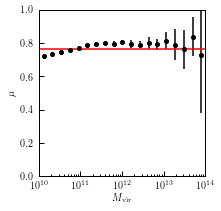

In [262]:
p = np.mean(inverse_alignment_strenth(k), axis=-1)
err_p = np.std(inverse_alignment_strenth(k), axis=-1)

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(mbins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
plt.plot([0.001,10**16], [full_sample_p, full_sample_p], '-', color='red')
plt.ylim([0,1])
plt.xlim([10**10,10**14])
plt.xscale('log')
plt.xlabel(r'$M_{\rm vir}$')
plt.ylabel(r'$\mu$')
plt.show()

In [260]:
# check for sub-halo ellipticity

q = halocat.halo_table['halo_b_to_a']
s = halocat.halo_table['halo_c_to_a']
e = (1.0-q)/(1.0+q)

ebins = np.logspace(-2,0.0,20)
ebins_centers = (ebins[:-1]+ebins[1:])/2.0
inds = np.digitize(e, bins=ebins)
Nboot=5
k = np.zeros((len(ebins)-1,Nboot))
for i in range(0,len(ebins)-1):
    mask = (inds==i) & np.isfinite(theta_ma)
    x = np.cos(theta_ma[mask])
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

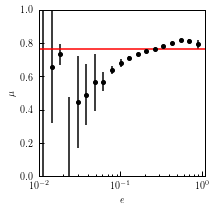

In [259]:
p = np.mean(inverse_alignment_strenth(k), axis=-1)
err_p = np.std(inverse_alignment_strenth(k), axis=-1)

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(ebins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
plt.plot([0.001,10**16], [full_sample_p, full_sample_p], '-', color='red')
plt.ylim([0,1])
plt.xlim([0.01,1.1])
plt.xscale('log')
plt.xlabel('$e$')
plt.ylabel(r'$\mu$')
plt.show()

## fit for hybrid model alignment

In [226]:
fs = np.linspace(0,1.0,11)
#fs = np.array([0,1])

v = np.zeros((len(fs),N,3))
for i,f in enumerate(fs):
    v[i,:,:] = normalized_vectors(f*r + (1.0-f)*host_major_axis)

In [227]:
rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0
inds = np.digitize(scaled_radius, bins=rbins)

k = np.zeros((len(fs), len(rbins)-1))
for j in range(len(fs)):
    theta_ma = angles_between_list_of_vectors(v[j,:,:], major_axis)
    for i in range(0,len(rbins)-1):
        mask = (inds==i+1) & np.isfinite(theta_ma)
        x = np.fabs(np.cos(theta_ma[mask]))
        uran = np.random.random(len(x))
        x[uran < 0.5] = -1.0*x[uran < 0.5]
        k[j,i] = d.fit(x, floc=0, fscale=1)[0]

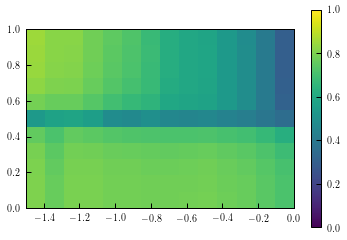

In [228]:
p = inverse_alignment_strenth(k)
plt.imshow(p, vmin=0.0, vmax=1, extent=[-1.5,0,0,1])
plt.colorbar()
plt.show()

## consider two vvector alignemnts


In [287]:
from intrinsic_alignments.ia_models.ia_model_components import DimrothWatson, inverse_alignment_strenth, alignment_strenth, axes_correlated_with_input_vector
from halotools.utils import angles_between_list_of_vectors

In [304]:
N = 100000

input_vectors = np.zeros((N,3))
ran = np.random.random(N)
xaxis = np.zeros((N,3))
xaxis[:,0]=1.0
input_vectors[ran<0.5,0] = 1.0
input_vectors[ran>=0.5,1] = 1.0
ps = np.ones(N)*0.9
output_vectors = axes_correlated_with_input_vector(input_vectors, p=ps)

In [305]:
theta = angles_between_list_of_vectors(output_vectors, xaxis)
x = np.cos(theta)

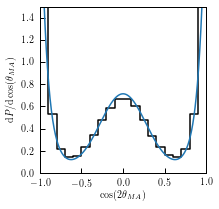

In [314]:
bins = np.linspace(-1,1,21)

counts = np.histogram(x, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

xx = np.linspace(-1,1,1000)
fig, ax = plt.subplots(1,1, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.3)
ax.step(costheta_bins[1:], counts, '-', color='black')
ax.plot(xx, 0.5*d.pdf(xx,k=alignment_strenth(0.9))+0.5*d.pdf(xx,k=alignment_strenth(-0.9)))
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(2\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')

In [310]:
alignment_strenth(0.9)

array([-6.31375151])